In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.fft import fft, ifft
from scipy.optimize import line_search
from tensorflow.python import tf2
from keras.datasets import mnist
from scipy.linalg import convolution_matrix
from PIL import Image, ImageOps


## Forward-Backward
We will use FB to minimize the function
$$f(x) + g(x) = \frac{1}{2 \lambda}\|Ax-y\|_2^2 + \|x\|_1$$
Let us for the time being omit the $\frac{1}{2\lambda}$ term. For the Forward-Backward method, we require $\nabla f$.
We can find this using directional derivatives. Rewriting, we have
$$f(x) = \|Ax-y\|_2^2 = (Ax-y)^T(Ax-y) = x^TA^TAx - 2x^TA^Ty + y^Ty.$$
The directional derivative of $f$ along $v$ is
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h}$$
$$= \lim_{h \xrightarrow{} 0} \frac{(x+hv)^TA^TA(x+hv) - 2(x+hv)^TA^Ty + y^Ty - x^TA^TAx + 2x^TA^Ty - y^Ty}{h}$$
$$
= \lim_{h \xrightarrow{} 0} 2x^TA^tAv + hv^TA^TAv - 2v^TA^Ty = v^T(2A^TAx - 2A^Ty).
$$
However, from Taylor expansion we also have
$$\nabla_v f(x) = \lim_{h \xrightarrow{} 0} \frac{f(x+hv) - f(x)}{h} \approx \lim_{h \xrightarrow{} 0} \frac{f(x) + hv^T\nabla f(x) - f(x)}{h} = v^T \nabla f(x).$$
Hence from the previous equation we also have
$$\nabla_v f(x) = v^T(2A^TAx - 2A^Ty) = v^T \nabla f(x),$$
and so
$$\nabla f(x) = 2A^TAx - 2A^Ty.$$
Now, the Forward-Backward Algorithm is given to us as
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla f(x_n)\right).$$
In the case that $R(x) = \|x\|_1$, we have
$$prox_{\gamma R}(x) = sign(x) \max{(|x|-\gamma,0)}.$$
Hence, for our current loss function, we have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{\lambda}\left(A^TAx - A^Ty\right)\right),$$
with $prox$ as above.

In [55]:
#Initializations
#Use these for random A,y.
features = 10;
samples = 30;
A = np.random.randn(features,samples)
#Try different matrices
y = np.random.randn(features)
lam = .9 * np.max( A.T @ y )

In [56]:
def errL2(A,x,y):   #Return L2 error of Ax-y
    dif = A@x - y
    return dif.T @ dif

In [57]:
def funcreg(A,x,y,lam):    #Return f(x)+g(x)
    dif = A@x - y
    fxgx = (1/(2*lam))* (dif.T @ dif) + np.linalg.norm(x,1)
    return fxgx

In [58]:
#Implement thresh/prox function for g(x) = ||1||_1
def prox(x,omg): 
    return np.sign(x) * np.maximum(np.abs(x)-omg,0)

In [59]:
def GradF(A,x,y):                   #Calculate gradient of ||Ax-y||_2^2
    return (((A.T @ A) @ x) - A.T @ y)

In [60]:
def SubdifTest(A,x,y,lam):          #Subdifferential Test to check for correct solution
    gradf = GradF(A,x,y)/lam
    return max(abs(gradf))

Final f(x)+g(x): 0.6012254643777802
Final soln: [ 0.          0.         -0.         -0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.
 -0.         -0.         -0.         -0.          0.          0.
 -0.         -0.          0.04558023 -0.         -0.          0.
  0.         -0.01794135  0.          0.         -0.          0.        ]
Subdifferential: 1.0082586448804125


Text(0.5, 1.0, 'ln(f(x)+g(x))')

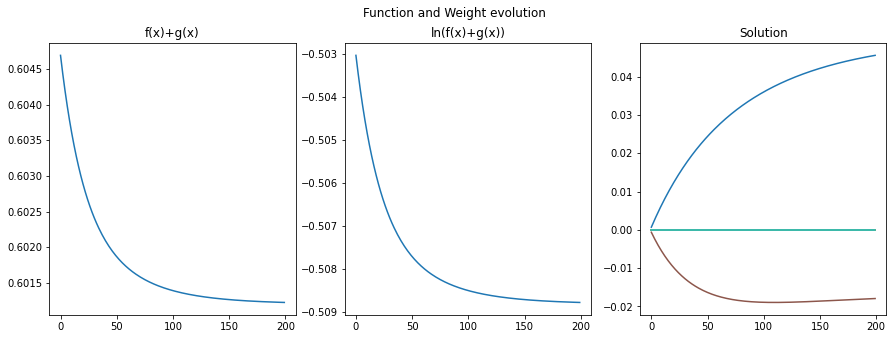

In [105]:
#Implement Forward Backward alg
#initialize x_0 = 0
x = np.zeros(samples)
niter = 200
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
for i in range(niter):
    #print("Iteration", i)
    x = prox(x - (omg/lam)*(np.dot(np.matmul(A.T,A),x) - np.dot(A.T,y)),omg)
    #fftx = np.fft.fft(x,10000)
    #fftdiff = fftk * fftx - ffty
    #gradconv = np.fft.ifft(fftkc * fftdiff,samples)
    #x = prox(x - (omg/lam)*gradconv,omg)
    xtemp[:,i] = x
    errvec[i] = errL2(A,x,y)
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs[0].plot(funcvec.T);
axs[0].set_title('f(x)+g(x)')
axs[2].plot(xtemp.T);
axs[2].set_title('Solution')
axs[1].plot(np.log(funcvec.T));
axs[1].set_title('ln(f(x)+g(x))')

## Gradient Descent
Now, by Theorem 2 in the paper, we have that $(\mathcal{P}_\lambda)$ is equivalent to
$$\min_{v \in \mathbb{R}^k} f(v) \triangleq \min_{u \in \mathbb{R}^n} G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right).$$

We will use $h(v \odot v) = \|v\|_2^2$ and $L$ as above. By Corollary 1, $u$ solves
$$(diag(v) X^TX diag(v) + \lambda I)u = v \odot_{\mathcal{G}} (X^Ty),$$
so that
$$u = (diag(v) X^TX diag(v) + \lambda I)^{-1} (v \odot_{\mathcal{G}} (X^Ty)).$$

In order to solve $\min_{v \in \mathbb{R}^k} f(v)$ by Gradient Descent, we find $\nabla f = \frac{\partial f}{\partial v}:$
$$\frac{\partial f}{\partial v} = \partial_v G(u,v) = v + \frac{1}{\lambda} \partial_v L.$$ Now, using chain rule, we have that, denoting $\omega = (v \odot_{\mathcal{G}} u),$
$$\frac{\partial L}{\partial v_i} = \nabla L \cdot \frac{\partial \omega}{\partial v_i},$$
that is
$$\frac{\partial L}{\partial v_i} = \frac{1}{\lambda}\left(X^TX (v \odot_{\mathcal{G}} u) - X^Ty \right) \cdot u',$$
where $u' = (0, \ldots, u_g, \ldots, 0)$. The above can also be reformulated (as per Proposition 3) as
$$\nabla f = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right)$$
We can now apply Gradient Descent.

In [106]:
def find_u(X,y,v,lam): 
    invm =  np.diag(v) @ (X.T @ (X @ np.diag(v))) + lam * np.eye(np.size(v))
    return np.linalg.inv(invm) @ (np.multiply(v,X.T @ y))

In [107]:
def Gradf(X,y,v,lam):
    u = find_u(X,y,v,lam)
    tempvec = v + (1/lam) * ( u * (X.T @ (X @ (v*u)) - X.T @ y))
    return tempvec

Final f(x)+g(x): 0.6015573307395327
Final soln: [ 8.85042998e-09  7.66362661e-12 -3.05210615e-07 -1.16945867e-10
  1.01694690e-12 -4.47532607e-08  1.06911113e-07 -4.95511516e-09
  6.90653248e-11 -4.20310594e-06 -1.64614007e-12  7.97959816e-05
 -9.70367583e-06 -1.31128600e-10 -5.67374081e-07 -3.70955934e-09
  6.30823479e-06 -4.41265061e-13 -6.11581791e-08 -3.12925164e-08
  4.86403320e-02 -5.48595308e-07 -3.37590557e-12  6.98045804e-09
  5.88117179e-06 -3.78082359e-03  1.05214627e-11  1.07255628e-06
 -8.01808101e-08  1.29103923e-07]
Subdifferential: 1.050208843273352


Text(0.5, 1.0, 'Solution')

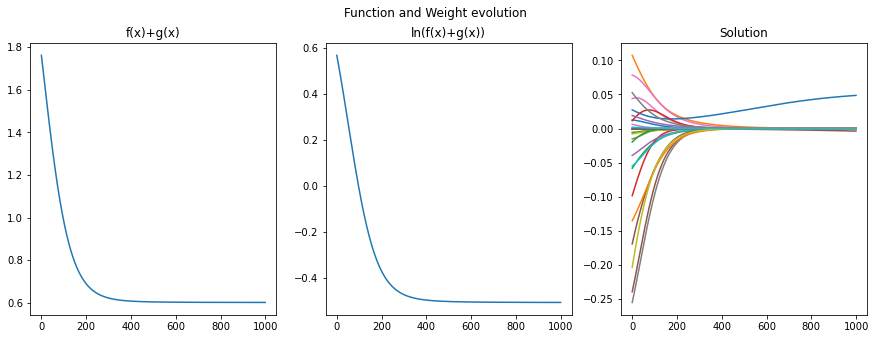

In [108]:
step = 0.01
niter = 1000
errvec2 = np.zeros(niter)
funcvec2 = np.zeros(niter)
v = np.random.randn(samples)
#v = np.zeros(samples)
xtemp2 = np.zeros((samples,niter))
for i in range(niter):
    #print("Iteration", i)
    grad = Gradf(A,y,v,lam)
    #grad = Gradf_conv(A,fftk,fftkc,y,v,lam)
    v = v - step*grad
    x = v * find_u(A,y,v,lam)
    #x = v * find_u_conv(fftk,fftkc,ffty,v,lam)
    xtemp2[:,i] = x
    errvec2[i] = errL2(A,x,y)
    funcvec2[i] = funcreg(A,x,y,lam)
    
print("Final f(x)+g(x):", funcvec2[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs2 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs2[1].plot(np.log(funcvec2.T));
axs2[1].set_title('ln(f(x)+g(x))')
axs2[0].plot(funcvec2.T);
axs2[0].set_title('f(x)+g(x)')
axs2[2].plot(xtemp2.T);
axs2[2].set_title('Solution')
    


## Gradient Descent on $u$ and $v$

Now we will compare convergence when using the SGD algorithm, as opposed to Gradient Descent.

Recall from above that if
$$G(u,v) = \frac{1}{2} h(v \odot v) + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right) = \frac{1}{2}\|v\|_2^2 + \frac{1}{2}\|u\|_2^2 + \frac{1}{\lambda}L \left(X(v \odot_{\mathcal{G}} u),y \right),$$ 
with L the square-loss function, then we have
$$\partial_v G(u,v) = v + \frac{1}{\lambda} \left( u \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$
Similarly, we have
$$\partial_u G(u,v) = u + \frac{1}{\lambda} \left( v \odot (X^\top X (v \odot_{\mathcal{G}} u) - X^\top y) \right).$$

Now our update step will look like
$$\begin{cases}
u_{k+1} = u_k - \gamma_k\partial_u G(u,v) \\
v_{k+1} = v_k - \gamma_k\partial_v G(u,v)
\end{cases}$$

Regarding which stepsize, $\omega_k$, to use: we can either update $\omega_k$ using Backtracking Line Search or using the Barzilai-Borwein algorithm.

[1]Gabriel Peyré. Mathematical Foundations of Data Sciences, 2021.

In [109]:
def Gux(u,v,X,y,lam):             #Our objective function G(u,v)
    dif = X@(u * v) - y
    return (v.T @ v)/2 + (u.T @ u)/2 + (1/lam)*(dif.T @ dif)

In [110]:
def GnabV(u,v,X,y,lam):
    return v + (1/lam)*u*((X.T @ X)@(v*u) - X.T @ y)

In [111]:
def GnabU(u,v,X,y,lam):
    return u + (1/lam)*v*((X.T @ X)@(v*u) - X.T @ y)

In [112]:
def LineSearchU(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for u minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabU(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux((u - omg*grad),v,X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

In [113]:
def LineSearchV(u,v,X,y,lam):            #Define the Armijo Backtracking Linesearch to find stepsize for v minimization
    tau = 1/2
    c = 1/2
    omg = .1/np.linalg.norm(X)
    grad = GnabV(u,v,X,y,lam)
    t = -c * grad.T @ grad
    while(Gux(u,v,X,y,lam) - Gux(u,(v - omg*grad),X,y,lam) < omg*t):
        omg = tau*omg
        
    return omg

Final f(x)+g(x): 0.6598956823851025
Final soln: [ 2.73900685e-03  7.87357252e-04  3.26246096e-04 -4.59667184e-05
  2.34627308e-03 -1.65265211e-04  3.47604344e-04 -1.55051177e-03
  5.22354215e-03 -5.99137649e-03 -1.86561524e-03  2.27882971e-02
 -4.83584430e-03 -2.31224664e-03 -2.72653488e-03 -6.45177592e-03
  2.24477578e-03 -2.23000227e-04 -1.35409826e-02 -4.89349640e-03
  8.29116845e-02 -1.56438090e-03  8.52083000e-04  3.31927913e-03
  3.97386326e-02 -5.28607626e-03  3.24703759e-04  3.74345959e-03
 -6.76595266e-04  9.26882316e-03]
Subdifferential: 0.9086233124262341


Text(0.5, 1.0, 'Stepsize')

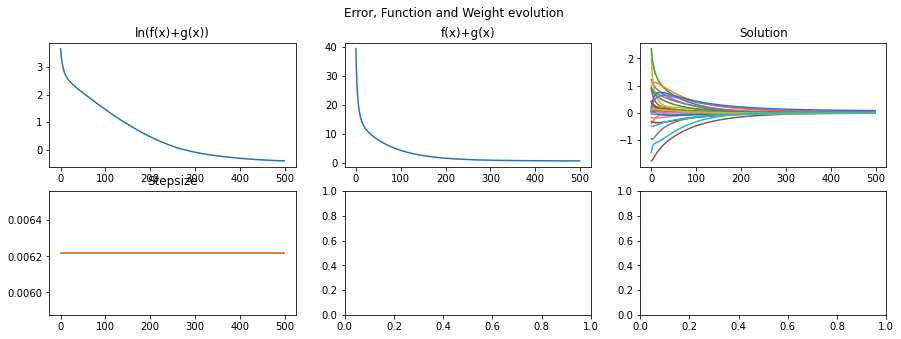

In [114]:
#Do gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 500
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [71]:
def BBstep(xt,xtm1,gradt,gradtm1):    #Function for Barzilai-Borwein stepsize
    st = xt - xtm1
    yt = gradt - gradtm1
    return (st.T @ st) / abs((st.T @ yt))

Final error: 0.6012113682670424
Final soln: [ 1.81573214e-15  3.42431673e-28 -1.15154750e-20 -2.64228888e-25
  3.99224435e-27 -1.60067386e-16  8.19477557e-16 -7.00884883e-23
  8.31877733e-15 -5.46064042e-06 -9.27705999e-26  2.95419092e-10
 -3.77591096e-09 -2.26921826e-28 -6.71330709e-15 -2.51610969e-28
  2.83309479e-14  1.59188002e-30 -1.34005360e-16 -5.55274802e-15
  5.14248292e-02 -2.15818666e-17 -1.74657951e-28  1.51820775e-20
  2.58352341e-12 -1.46901136e-02  1.09847184e-26  1.75580377e-14
 -1.05816601e-15  2.99531424e-14]
Subdifferential: 1.00620872616502


Text(0.5, 1.0, 'Stepsize')

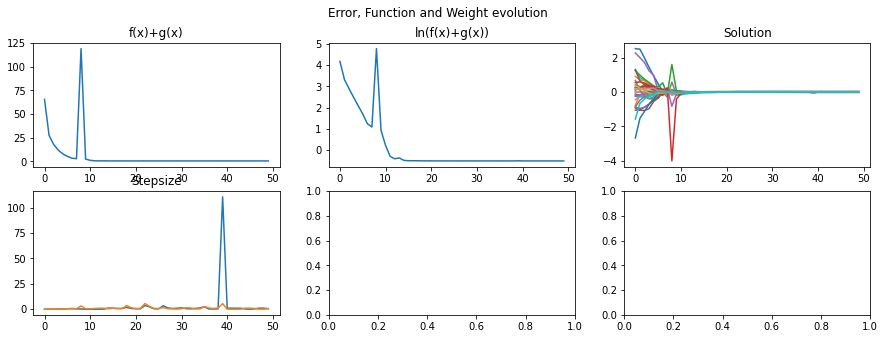

In [73]:
#Do gradient descent with step chosen using Barzilai-Borwein
step = 0.001
niter = 50
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
for i in range(niter):
    #rndindx = np.random.randint(0, samples, 1)[0]
    #ch_sample = A[:,rndindx].reshape(-1,1)
    gradu = GnabU(u,v,A,y,lam)
    gradv = GnabV(u,v,A,y,lam)
    #stepu = LineSearchU(u,v,ch_sample,y,lam)
    #stepv = LineSearchV(u,v,ch_sample,y,lam)
    stepu = .1/np.linalg.norm(A)
    stepv = .1/np.linalg.norm(A)
    if(i > 0):
        stepu = BBstep(u,uold,GnabU(u,v,A,y,lam),GnabU(uold,vold,A,y,lam))
        stepv = BBstep(v,vold,GnabV(u,v,A,y,lam),GnabV(uold,vold,A,y,lam))
    
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    uold = u
    vold = v
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final error:", funcvec3[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec3.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec3.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

In [27]:
#Now try with real data - load MNIST digits
#(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Stochastic Gradient Descent
Now, note that
$$\frac{1}{2}\|Ax-y\|_2^2 = \frac{1}{2}\sum^m_{i=1} \left(\langle A_i, x \rangle - y_i \right)^2 = \frac{1}{2}\sum^m_{i=1} Q_i = \frac{1}{2}\sum^m_{i=1} L_i^2 $$

Thus, a partial derivative w.r.t $x_i$ is just
$$\nabla Q_i(x) = L_i \cdot A_i^T,$$

where $A_i$ is the $i$-th row of the matrix $A$, corresponding to the $i$-th sample.

Furrthermore, if we have that $x = u \odot v,$ then by chain rule we have
$$\nabla_u Q_i(x) = L_i \cdot A_i^T \odot v.$$
$$\nabla_v Q_i(x) = L_i \cdot A_i^T \odot u.$$

In [74]:
#Check that sum of gradient is gradient of the sum
x = np.zeros(samples)
diff = A@x-y
grad = np.zeros(samples)
for i in range(features):
    grad = grad + diff[i] * A[i,:].T
    
print(np.linalg.norm(grad - GradF(A,x,y)))

1.2473035753480422e-15


In [86]:
print(np.size(A,0))

10


In [93]:
def SGnabV(u,v,X,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    features = np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return v + (1/lam)*Li*(Xi.T @ u)

In [94]:
def SGnabU(u,v,X,y,lam,indx):             #Stochastic Gradient for U
    Xi = X[indx,:]
    np.size(X,0)
    Li = Xi @ (u*v) - y[indx]
    return u + (1/lam)*Li*(Xi.T @ v)

Final f(x)+g(x): 0.6048296526545109
Final soln: [-1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64 -1.57341559e-64
 -1.57341559e-64 -1.57341559e-64]
Subdifferential: 1.1111111111111112


Text(0.5, 1.0, 'Stepsize')

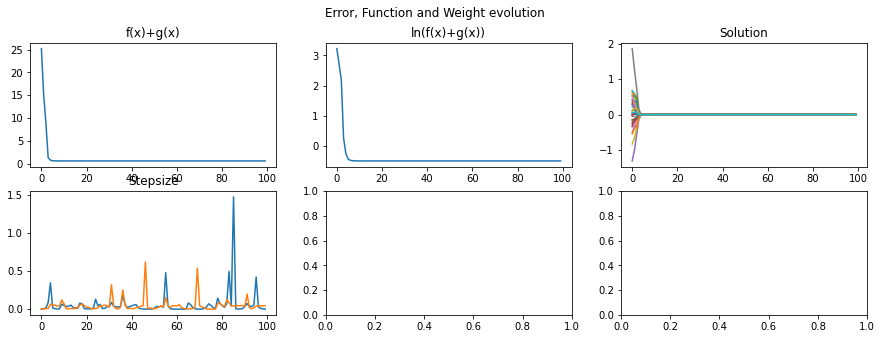

In [95]:
#Do stochastic gradient descent with step chosen using Barzilai-Borwein (SGD-BB in the paper)
step = 0.001
niter = 100
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp = np.zeros((samples,niter))
funcvec = np.zeros(niter)
steparr = np.zeros((2,niter))
uold = u
vold = v
epoch_sz = 20
epoch_u = 0
epoch_v = 0
beta = 0.5
for i in range(niter):

    
    if(i > 0):
        #stepu = (1/m) * BBstep(u,uold,gradu,SGnabU(uold,vold,A,y,lam,rndindx))
        #stepv = (1/m) * BBstep(v,vold,gradv,SGnabV(uold,vold,A,y,lam,rndindx))
        stepu = (1/epoch_sz) * BBstep(u,uold,gradu_avg,gradu_avg_old)
        stepv = (1/epoch_sz) * BBstep(v,vold,gradv_avg,gradv_avg_old)
        steparr[0,i] = stepu
        steparr[1,i] = stepv
    
    uold = u
    vold = v
    if (i == 0):
        stepu = .1/np.linalg.norm(A)
        stepv = .1/np.linalg.norm(A)
        gradu_avg = 0
        gradv_avg = 0
    gradu_avg_old = gradu_avg
    gradv_avg_old = gradv_avg
    gradu_avg = 0
    gradv_avg = 0
    for t in range(epoch_sz):
        rndindx = np.random.randint(0, features)
        gradu = SGnabU(u,v,A,y,lam,rndindx)
        gradv = SGnabV(u,v,A,y,lam,rndindx)
        u = u - stepu * gradu
        v = v - stepv * gradv
        gradu_avg = beta * gradu + (1-beta) * gradu_avg
        gradv_avg = beta * gradv + (1-beta) * gradv_avg
    
    xtemp[:,i] = u * v
    funcvec[i] = funcreg(A,(u * v),y,lam)
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", u * v)
print("Subdifferential:", SubdifTest(A,u * v,y,lam))

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs3[0,1].plot(np.log(funcvec.T));
axs3[0,1].set_title('ln(f(x)+g(x))')
axs3[0,0].plot(funcvec.T);
axs3[0,0].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

Final f(x)+g(x): 0.6259701529691108
Final soln: [ 1.11800973e-03 -4.78595718e-04 -7.82490009e-06 -7.08985790e-05
  2.43878502e-03  6.30570750e-04  3.23236219e-03  3.36631900e-04
 -3.62464242e-04 -8.34224677e-04 -2.26713565e-04 -3.07600345e-05
  9.10023998e-04  3.87919580e-03  2.53721413e-04  1.20050436e-03
  5.69270645e-04  7.08814215e-04  1.90238990e-04  2.43650568e-04
  1.41694275e-03  7.51270252e-04  3.45664452e-04  9.21379941e-04
  1.65274508e-03  3.19176299e-04  6.65980145e-05  6.70750232e-04
  7.50594804e-04  1.23884320e-03]
Subdifferential: 1.1051936069769166


Text(0.5, 1.0, 'Stepsize')

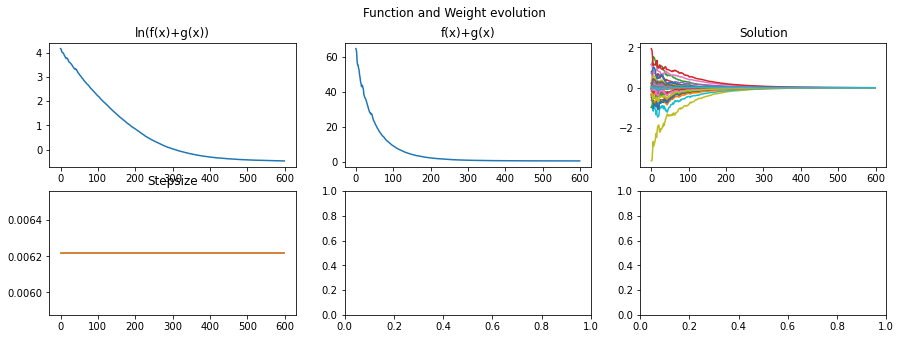

In [96]:
#Do stochastic gradient descent with step chosen using Armijo Backtracking Line Search
step = 0.001
niter = 600
errvec3 = np.zeros(niter)
u = np.random.randn(samples)
v = np.random.randn(samples)
xtemp3 = np.zeros((samples,niter))
funcvec3 = np.zeros(niter)
steparr = np.zeros((2,niter))
for i in range(niter):
    rndindx = np.random.randint(0, features)
    gradu = SGnabU(u,v,A,y,lam,rndindx)
    gradv = SGnabV(u,v,A,y,lam,rndindx)
    stepu = LineSearchU(u,v,A,y,lam)
    stepv = LineSearchV(u,v,A,y,lam)
    steparr[0,i] = stepu
    steparr[1,i] = stepv
    u = u - stepu*gradu
    v = v - stepv*gradv
    x = u * v
    xtemp3[:,i] = x
    errvec3[i] = errL2(A,x,y)
    funcvec3[i] = funcreg(A,x,y,lam)
    #print(stepu)
    
print("Final f(x)+g(x):", funcvec3[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs3 = plt.subplots(2,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs3[0,0].plot(np.log(funcvec3.T));
axs3[0,0].set_title('ln(f(x)+g(x))')
axs3[0,1].plot(funcvec3.T);
axs3[0,1].set_title('f(x)+g(x)')
axs3[0,2].plot(xtemp3.T);
axs3[0,2].set_title('Solution')
axs3[1,0].plot(steparr.T);
axs3[1,0].set_title('Stepsize')

# Stochastic Forward-Backward

We modify the F-B algorithm to work with SGD, rather than batch descent.

We have the F-B iteration
$$x_{n+1} = prox_{\gamma R}\left(x_n - \gamma \nabla_{i} f(x_n)\right).$$
That is,
$$x_{n+1} = prox_{\gamma R}\left(x_n - \frac{\gamma}{m} \sum_{j=1}^m g_j\right),$$
where
$$\mathbb{E} \left(\frac{1}{m}\sum_{j=1}^m g_j \right) = \nabla f(x_n)$$
and
$$ g_j = \frac{1}{\lambda}L_i \cdot A_i^T,$$
with $prox, L_i, A_i$ as above.

In [39]:
def SGnabX(X,x,y,lam,indx):             #Stochastic Gradient for V
    Xi = X[indx,:]
    Li = Xi @ x - y[indx]
    return(1/lam)*Li*Xi.T

Final f(x)+g(x): 0.61190281619599
Final soln: [ 0.         -0.00116102  0.         -0.          0.          0.
  0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.00049463 -0.          0.00471338  0.
 -0.         -0.          0.         -0.          0.          0.0062088
 -0.         -0.00141878 -0.         -0.         -0.00080488  0.        ]
Subdifferential: 1.1000309563354236


Text(0.5, 1.0, 'Solution')

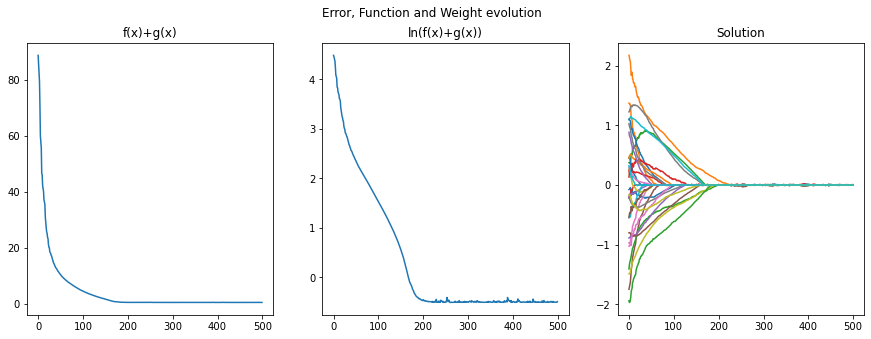

In [126]:
#Implement batch SGD Forward Backward alg
#initialize x_0 = 0
x = np.random.randn(samples)
grad = np.zeros(features)
niter = 500
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
mbs = round(features*0.8)        #minibatch size
for i in range(niter):
    grad = np.zeros(samples)
    for j in range(mbs):          #Iterate over minibatch
        rndindx = np.random.randint(0, features)
        grad = grad + SGnabX(A,x,y,lam,rndindx)
    
    #grad = (1/mbs)*grad              #<---  It seems dividing by the batch size causes the algorithm to perform worse.
    x = prox(x - omg *grad,omg)
    xtemp[:,i] = x
    #errvec[i] = errL2(A,x,y)
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs4 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Error, Function and Weight evolution')
axs4[0].plot(funcvec.T);
axs4[0].set_title('f(x)+g(x)')
axs4[1].plot(np.log(funcvec.T));
axs4[1].set_title('ln(f(x)+g(x))')
axs4[2].plot(xtemp.T);
axs4[2].set_title('Solution')


# Dual Averaging Method

In [98]:
def RDAstep(gt,t,lam,rho):
    lRDA = lam + rho/np.sqrt(t)
    x = np.zeros(np.size(gt))
    for i in range(np.size(gt)):
        if abs(gt[i]) <= lRDA:
            x[i] = 0
        else:
            x[i] = -np.sqrt(t) * (gt[i] - lRDA*np.sign(gt[i]))
            
    return x

In [101]:
def avgsubg(gt,gtm1,t):
    return ((t-1)/t) * gtm1 + (1/t) * gt

Final f(x)+g(x): 0.6048296526545109
Final soln: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Subdifferential: 1.1111111111111112


<ipython-input-122-e2a82f85766f>:30: RuntimeWarning: divide by zero encountered in log
  axs5[1].plot(np.log(funcvec.T));


Text(0.5, 1.0, 'ln(f(x)+g(x))')

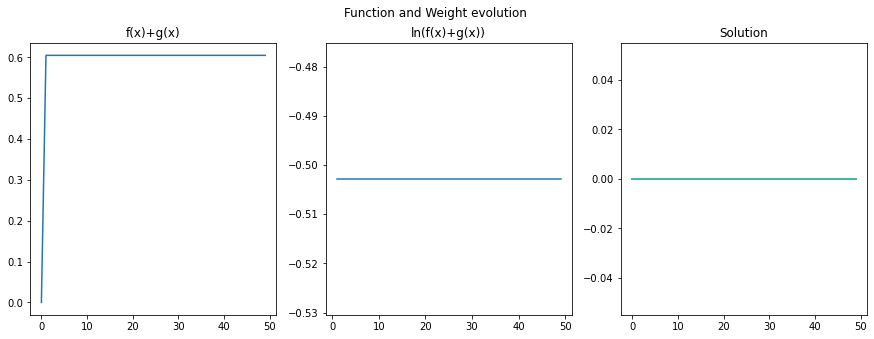

In [122]:
#Incorporate the RDA method as defined in paper by Lin Xiao
x = np.zeros(samples)
gt = np.zeros(samples)
niter = 50
xtemp = np.zeros((samples,niter))
errvec = np.zeros(niter)
funcvec = np.zeros(niter)
omg = .1/np.linalg.norm(A)
rho = 0.1

for i in range(1,niter):
    gtm1 = gt
    gt = GradF(A,x,y)/lam
    gtavg = avgsubg(gt,gtm1,i)
    x = RDAstep(gtavg,i,lam,rho)
    xtemp[:,i] = x
    funcvec[i] = funcreg(A,x,y,lam)
    
    
print("Final f(x)+g(x):", funcvec[-1])
print("Final soln:", x)
print("Subdifferential:", SubdifTest(A,x,y,lam))

fig, axs5 = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Function and Weight evolution')
axs5[0].plot(funcvec.T);
axs5[0].set_title('f(x)+g(x)')
axs5[2].plot(xtemp.T);
axs5[2].set_title('Solution')
axs5[1].plot(np.log(funcvec.T));
axs5[1].set_title('ln(f(x)+g(x))')